### Fitting exponential distributions with LMfit

In this notebook we will simulate and fit exponential-decay distribution data with one or multiple exponentials.
For the fit we will use the LMfit library and various optimization methods, especially dual annealing and LM algorithm as well as various objective functions like MSE or Maximum Likelihood.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lmfit
from exponential_distributions import exp1_dist, exp2_dist, exp3_dist, exp4_dist, LogLike

## Single-Exponential Decay

In [21]:
# simulate single exponential decay data with tau=10
tau_theory = 10
exp1_data = np.random.exponential(scale=tau_theory, size=10000, )

## Least-Squares Method

Let's perform a simple Least-Squares curve fit using the Model class from lmfit. This fit can only be done on a residuals objective function so we have to bin the data and generate a curve

In [22]:
from lmfit import Model
exp1_model = Model(exp1_dist)
print(f'parameter names: {exp1_model.param_names}')
print(f'independent variables: {exp1_model.independent_vars}')

params = exp1_model.make_params() # initialize the model parameters
exp1_model.set_param_hint('tau', value=2, min=0.1, max=1000)

parameter names: ['tau']
independent variables: ['t']


In [23]:
# bin the data into a given number of bins
values, bins = np.histogram(exp1_data, bins=20, range=(0, 30), density=True)
centers = (bins[1:] + bins[:-1])/2

In [24]:
# Fit using the default Levenberg-Marquardt algorithm
result = exp1_model.fit(values, t=centers)
print(result.fit_report())

[[Model]]
    Model(exp1_dist)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 20
    # variables        = 1
    chi-square         = 8.8060e-05
    reduced chi-square = 4.6347e-06
    Akaike info crit   = -244.664567
    Bayesian info crit = -243.668835
[[Variables]]
    tau:  9.28445645 +/- 0.15236113 (1.64%) (init = 2)


In [25]:
# Fit using the dual_annealing algorithm from scipy
result = exp1_model.fit(values, t=centers, method='dual_annealing')
print(result.fit_report())

[[Model]]
    Model(exp1_dist)
[[Fit Statistics]]
    # fitting method   = dual_annealing
    # function evals   = 2043
    # data points      = 20
    # variables        = 1
    chi-square         = 8.8060e-05
    reduced chi-square = 4.6347e-06
    Akaike info crit   = -244.664558
    Bayesian info crit = -243.668826
[[Variables]]
    tau:  9.28402000 +/- 0.15031624 (1.62%) (init = 2)


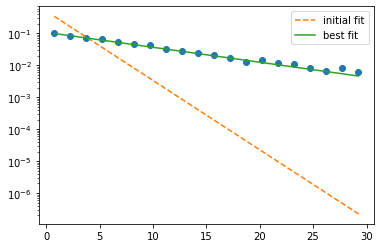

In [26]:
plt.plot(centers, values, 'o')
plt.plot(centers, result.init_fit, '--', label='initial fit')
plt.plot(centers, result.best_fit, '-', label='best fit')
plt.yscale('log')
plt.legend()
plt.show()

## Maximum Likelihood Method

### Single-exponential decay

We will now use the Maximum Likelihood method to fit our data without the need to bin it. For this purpose we will use the Minimizer class of lmfit. 

But first let's inspect visually the log-likelihood for a single exponential and  calculate the exact minimization parameter which is simply the average of our exponential data

In [ ]:
# Plot the log-likelihood for the exp1_dist model for various tau
llikes = []
tau_space = np.arange(0.1, 50, 0.01)
for tau_t in tau_space:
    llikes.append(LogLike([tau_t], exp1_dist, exp1_data))
plt.plot(tau_space, llikes, label='log-likelihood')
plt.ylabel('log-likelihood')
plt.xlabel('tau')
plt.legend()
print('Minimum at tau =', tau_space[np.argmin(llikes)])
print('data average:', np.average(exp1_data))

We can now use the Minimizer class and see if we arrive at the same result

In [ ]:
from lmfit import Minimizer, Parameter, Parameters

tau_param = Parameter('tau', value=2, min=0.1, max=100)
params = Parameters()
params.add(tau_param)

minim = Minimizer(LogLike, params, fcn_args=(exp1_dist, exp1_data))

In [ ]:
list(params.valuesdict().values())

In [ ]:
res = minim.minimize(method='dual_annealing')
print(lmfit.fit_report(res))

### Double-exponential decay

We can now generate some double-exponential data from a random distribution.

In [ ]:
from scipy.stats import rv_continuous

class exp2_gen(rv_continuous):

    "Double-Exponential Decay distribution"

    def _pdf(self, t, p, tau1, tau2):
        
        return p/tau1*np.exp(-t/tau1)+(1-p)/tau2*np.exp(-t/tau2)

exp2_pdf = exp2_gen(name='double-exponential', a=0)

In [ ]:
p = 0.6
tau1 = 1
tau2 = 10
# exp2_data = exp2_pdf.rvs(p, tau1, tau2, size=1000)

In [ ]:
from exponential_distributions import log_bin
# cent_log, val_log = log_bin(exp2_data, bin_width=0.5)

In [ ]:
# another way before we plot them together
def exp2_gen2(p, tau1, tau2, size=100):
    np.random.seed(1)
    s = np.random.random(size=size)
    exp1 = np.random.exponential(scale=tau1, size=size)
    exp2 = np.random.exponential(scale=tau2, size=size)
    data = np.zeros(size)
    from1 = np.where(s < p)
    from2 = np.where(s >= p)
    data[from1] = exp1[from1]
    data[from2] = exp2[from2]
    return data
        
    

In [ ]:
exp2_data2 = exp2_gen2(p, tau1, tau2, size=100)


In [ ]:
cent_log2, val_log2 = log_bin(exp2_data2, bin_width=0.5)
plt.plot(cent_log2, val_log2)
# plt.plot(cent_log, val_log)
plt.xscale('log')
plt.yscale('log')

#### Fit with `dual_annealing`

In [ ]:
params = Parameters()
params.add('p', value=0.5, min=0, max=1)
params.add('tau1', value=0.2, min=0.1, max=100)
params.add('tau2', value=8, min=0.1, max=100)

#Let's sample once again
exp2_data2 = exp2_gen2(p, tau1, tau2, size=10000)
exp2_data2 = exp2_data2[exp2_data2 > 0.1] # Discard the very small dwells so we don't get an error in the log

minim = Minimizer(LogLike, params, fcn_args=(exp2_dist, exp2_data2))

In [ ]:

res = minim.minimize(method='dual_annealing')
print(lmfit.fit_report(res))

In [ ]:
# bin the data into normal scale
values, bins = np.histogram(exp2_data2, bins=50, range=(0, 30), density=True)
centers = (bins[1:] + bins[:-1])/2

In [ ]:
# get the list of best optimal parameters
pinit = list(params.valuesdict().values())
popt = list(res.params.valuesdict().values())
popt

In [ ]:
plt.plot(centers, values, 'o')
plt.plot(centers, exp2_dist(centers, *pinit), '--', label='initial fit')
plt.plot(centers, exp2_dist(centers, *popt), '-', label='best fit')
plt.yscale('log')
plt.legend()
plt.show()

### Generalize the exponential distribution generator to n exponentials

In [ ]:
def exp_gen(p, tau, size=100, seed=None):
    """Generate exponential decay random variables for a given number of exponentials.

    Args:
        p (list): The population ratio between the first n - 1 exponentials. sum(p) must be < 1.
        tau (list): The lifetimes corresponding to the number of exponentials. Must be positive.

    Returns:
        A 1D ndarray of size `size`. The sample from the (multi)exponential decay prob. distribution
        
    Raises:
        ValueError: if sum(p) > 1 or any element from tau < 0
    """
    if type(p) != list or type(tau) != list or sum(p) > 1:
        raise ValueError('p and tau must be of type list and sum(p) > 0')
        
    for t in tau:
        if t < 0:
            raise ValueError('All taus must be positive numbers')
            
    # Sort p in descending order
    ps = p
    ps.append(1 - sum(p)) # find the probability corresponding to the last tau
    # Sort tau in the same order as p
    taus = [x for _, x in sorted(zip(ps, tau), reverse=True)]
    ps = sorted(ps, reverse=True)
    
    
    if seed is not None:
        np.random.seed(seed)
        
    s = np.random.random(size)
    exp = np.zeros((len(taus), size))
    
    
    for i, tt in enumerate(taus):
        exp[i] = np.random.exponential(scale=tt, size=size)

    data = np.zeros(size)
    for i, pi in enumerate(ps):
        
        if i == 0:
            idx = np.where(s < pi)
            data[idx] = exp[i, idx]
            
        elif i == len(ps) - 1:
            idx = np.where(s > sum(ps[:-1]))
            data[idx] = exp[i, idx]
            
        else:
            idx = np.where((s < sum(ps[:i+1])) & (s > sum(ps[:i])))
            data[idx] = exp[i, idx]

    return data

### Triple-exponential decay

In [ ]:
data = exp_gen([0.3, 0.5], [1, 10, 100], size=10000)

In [ ]:
params = Parameters()

params.add('p1', value=0.2, min=1e-6, max=1)
params.add('p2', value=0.2, min=1e-6, max=1)


params.add('tau1', value=0.2, min=0.1, max=100)
params.add('tau2', value=7, min=0.1, max=1000)
params.add('tau3', value=90, min=0.1, max=1000)


data = data[data > 0.01] # Discard the very small dwells so we don't get an error in the log

minim = Minimizer(LogLike, params, fcn_args=(exp3_dist, data))


In [ ]:
res = minim.minimize(method='dual_annealing')
print(lmfit.fit_report(res))

In [ ]:
values, bins = np.histogram(data, bins=50, range=(0, 200), density=True)
centers = (bins[1:] + bins[:-1])/2
# get the list of best optimal parameters
pinit = list(params.valuesdict().values())
popt = list(res.params.valuesdict().values())

plt.plot(centers, values, 'o')
plt.plot(centers, exp3_dist(centers, *pinit), '--', label='initial fit')
plt.plot(centers, exp3_dist(centers, *popt), '-', label='best fit')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
plt.figure()
cent, val = log_bin(data, bin_width=0.2)
plt.plot(cent, exp3_dist(cent, *popt))
plt.plot(cent, val, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.1, 10000)

### Four-exponential decay

In [ ]:
data4 = exp_gen([0.3, 0.2, 0.4], [1, 10, 100, 500], size=10000)

In [ ]:
params = Parameters()

params.add('p1', value=0.2, min=1e-6, max=1)
params.add('p2', value=0.2, min=1e-6, max=1)
params.add('p3', value=0.2, min=1e-6, max=1)


params.add('tau1', value=0.2, min=0.1, max=100)
params.add('tau2', value=7, min=0.1, max=1000)
params.add('tau3', value=90, min=0.1, max=1000)
params.add('tau4', value=100, min=0.1, max=1000)



data = data[data > 0.01] # Discard the very small dwells so we don't get an error in the log

minim = Minimizer(LogLike, params, fcn_args=(exp4_dist, data))


In [ ]:
res = minim.minimize(method='dual_annealing')
print(lmfit.fit_report(res))

In [ ]:
# get the list of best optimal parameters
pinit = list(params.valuesdict().values())
popt = list(res.params.valuesdict().values())

In [ ]:
plt.figure()
cent, val = log_bin(data4, bin_width=0.2)
plt.plot(cent, exp4_dist(cent, *popt))
plt.plot(cent, val, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.1, 10000)